# Анализ и подготовка данных
В данном ноутбуке производится анализ набора данных и его подготовка для дальнейшего использования.

## Анализ данных

In [8]:
! unzip -qq /app/data/raw/train_dataset_train.zip -d /app/data/raw/train/
! unzip -qq /app/data/raw/test_dataset_test.zip -d /app/data/raw/test/
! chmod -R 777 /app/data/raw/

In [20]:
import pandas as pd

In [21]:
df = pd.read_csv("/app/data/raw/train/train.csv")
df.head()

,ID_img,count_region,region_shape
0,3436.JPG,0.0,0.0
1,3437.JPG,0.0,0.0
2,3438.JPG,0.0,0.0
3,3439.JPG,0.0,0.0
4,3440.JPG,0.0,0.0


In [22]:
print(f'Общее количество данных для обучения: {len(df)}')

Общее количество данных для обучения: 5162


In [30]:
dfp = df[df['count_region'] != 0]
dfp.head()

,ID_img,count_region,region_shape
8,3444.jpg,1.0,"['{""cx"":2259,""cy"":391,""r"":64}']"
217,3653.JPG,1.0,"['{""cx"":2719,""cy"":2097,""r"":75}']"
254,3690.JPG,1.0,"['{""cx"":2914,""cy"":1693,""r"":90}']"
399,3835.JPG,2.0,"['{""cx"":2549,""cy"":2329,""r"":80}', '{""cx"":2437,""..."
511,3947.JPG,1.0,"['{""cx"":3130,""cy"":1370,""r"":134}']"


In [31]:
print(f'Количество данных с разметкой: {len(dfp)}')

Количество данных с разметкой: 58


In [24]:
dfb = df[df['count_region'] == 0]
print(f'Количество данных без разметки: {len(dfb)}')

Количество данных без разметки: 5104


### Формирование набора данных на которых есть люди

In [25]:
from pathlib import Path
import shutil
import tqdm

all_img_path = "/app/data/raw/train/train/"
people_img_path = "/app/data/interim_v3/images/train/"

Path(people_img_path).mkdir(parents=True, exist_ok=True)

for img in tqdm.tqdm(dfp["ID_img"]):
    # print(img)
    shutil.copyfile(all_img_path+img, people_img_path+img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 71.96it/s]


### Преобразование разметки в формат YOLO

In [26]:
import json
import magic
import re

import sys
sys.path.append('/app/src')
from markup_convertors import task2bb, bb2yolo

label = "0 "
people_label_path = "/app/data/interim_v3/labels/train/"

Path(people_label_path).mkdir(parents=True, exist_ok=True)

for index, row in tqdm.tqdm(dfp.iterrows()):
    count = row["count_region"]
    markup = row["region_shape"].replace("[","").replace("]","").replace("'","").split(", ")
    t = magic.from_file(people_img_path + row["ID_img"])
    wh = t.split(" ")[-3].replace(",","").split("x")
    image_w = int(wh[0])
    image_h = int(wh[1])
    file = open(people_label_path + row["ID_img"].replace("JPG","txt").replace("jpg","txt"), "w")
    for mkup in markup:
        mk = json.loads(mkup)
        bbox = task2bb(mk["cx"], mk["cy"], mk["r"]/2)
        yolo_lbl = bb2yolo(bbox, image_w, image_h)
        yolo_lbl = [str(x) for x in yolo_lbl]
        file.write(label + " ".join(yolo_lbl) + "\n")
    file.close()


58it [00:00, 483.51it/s]


In [41]:
dataset_path = "/app/data/interim_v3/dataset.yaml"
info = """train: ./images/train/

# number of classes
nc: 1

# class names
names: ['person']
"""

with open(dataset_path, "w") as f:
    f.write(info)

In [42]:
! chmod -R 777 /app/data/interim_v3/

In [14]:
# Check resolution

people_img_path = "/app/data/interim_v3/images/train/"

people_h = []
people_w = []

for _, row in tqdm.tqdm(dfp.iterrows()):
    t = magic.from_file(people_img_path + row["ID_img"])
    wh = t.split(" ")[-3].replace(",","").split("x")
    image_w = int(wh[0])
    image_h = int(wh[1])
    people_h.append(image_h)
    people_w.append(image_w)

58it [00:00, 479.69it/s]


(array([[ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 51.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.]]),
 array([3000. , 3064.8, 3129.6, 3194.4, 3259.2, 3324. , 3388.8, 3453.6,
        3518.4, 3583.2, 3648. ]),
 array([4000. , 4147.2, 4294.4, 4441.6, 4588.8, 4736. , 4883.2, 5030.4,
        5177.6, 5324.8, 5472. ]),
 <matplotlib.collections.QuadMesh at 0x7f5374901850>)

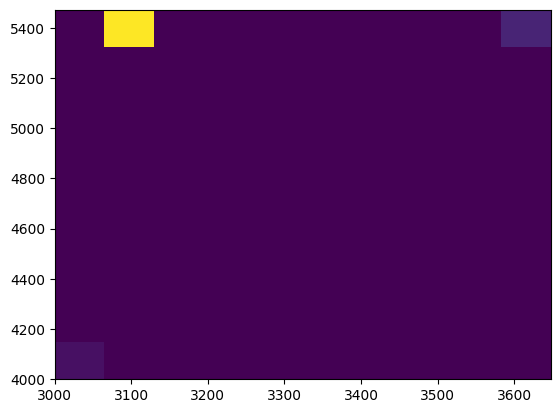

In [15]:
import matplotlib.pyplot as plt
import numpy as np

people_h = np.array(people_h)
people_w = np.array(people_w)

# print(people_h.stats())

# plt.histogramm2d(people_h, density=True, bins=30)
plt.hist2d(people_h, people_w, bins=10)

In [17]:
back_img_path = "/app/data/raw/train/train/"

back_h = []
back_w = []

for _, row in tqdm.tqdm(dfb.iterrows()):
    t = magic.from_file(back_img_path + row["ID_img"])
    wh = t.split(" ")[-3].replace(",","").split("x")
    image_w = int(wh[0])
    image_h = int(wh[1])
    back_h.append(image_h)
    back_w.append(image_w)

5104it [00:07, 657.36it/s]


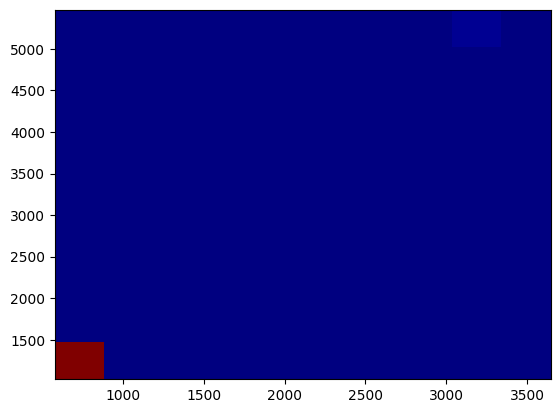

In [18]:
back_h = np.array(back_h)
back_w = np.array(back_w)

# print(people_h.stats())

# plt.histogramm2d(people_h, density=True, bins=30)
_ = plt.hist2d(back_h, back_w, bins=10, cmap=plt.cm.jet)

In [19]:
print(set(back_h))
print(set(back_w))

{576, 768, 3648, 3078, 683}
{1024, 5472}
